In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
import shutil
import getpass
from tqdm import tqdm

import torch
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
import torch.nn.functional as F
from torchinfo import summary
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)

pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y%m%d_%H%M%S'))
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

insert ./src
['./src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
Timestamp:  2024_05_01_10:05:08


In [3]:
# import shutil
# import getpass
# from tqdm import tqdm

# Setup

In [4]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"
"""Sample module for using DNN classifier with SNNL"""

# import argparse
# import torch
# from pt_datasets import create_dataloader, load_dataset
# from pt_datasets import display_cellpainting_batch
# from snnl.models import DNN
from snnl.utils import parse_args, get_hyperparameters, set_global_seed, get_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_train_metrics
from snnl.utils import display_epoch_metrics, display_model_history, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary
from dev_base import Model
from dev_dnn  import DNN 
from dev_autoencoder import Autoencoder
from dev_snnloss import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [101]:
current_device = get_device()
print(f"Current device is : {current_device}")

(22980132864, 34069872640)
(30267736064, 34069872640)
(12617121792, 12774539264)
Running on: cuda:0 Quadro GV100 0
Current device is : cuda:0


### main(args)

In [6]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration      hyperparameters/autoencoder_cellpainting.json"
             # f" --configuration    hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args
set_global_seed(args.seed)
## Autoencoder
(   dataset,
    batch_size,
    epochs,
    learning_rate,
    input_shape,
    code_units,
    units,
    activations,
    snnl_factor,
    temperature,
    cellpainting_args
) = get_hyperparameters(args.configuration)


Namespace(seed=1234, model='snnl', configuration='hyperparameters/autoencoder_cellpainting.json')

common cellpainting hyperparameters
loading autoencoder hyperparameters
loading autoencoder_cellpainting hyperparms


In [7]:
# units = [[1471, 1024], [1024, 1024], [1024, 512], [512,32] ]
# batch_size = 1
# compounds_per_batch = 100

 
if dataset == "cellpainting": 
    # cellpainting_args['batch_size']   = batch_size
    # cellpainting_args['compounds_per_batch'] = compounds_per_batch
    # cellpainting_args['train_start']  = 0
    # cellpainting_args['train_end']    = 240_000
    # cellpainting_args['val_start']    = 0
    # cellpainting_args['val_end']      = 24_000
    # cellpainting_args['sample_size'] = 3
    pass

In [8]:
trn_file_sz = cellpainting_args['train_end'] - cellpainting_args['train_start']
val_file_sz = cellpainting_args['val_end'] - cellpainting_args['val_start']
smp_sz = cellpainting_args['sample_size']
buf_sz = cellpainting_args['compounds_per_batch']
bth_sz = batch_size
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 800
 - Rows covered by 800 full size batches (300 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (300 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



In [9]:
print(f"   dataset           {dataset}")
print(f"   batch_size        {batch_size}")
print(f"   epochs            {epochs}")
print(f"   learning_rate     {learning_rate}")
print(f"   code_units        {code_units}")
print(f"   units             {units}")
print(f"   activations       {activations}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")
print()
if dataset == "cellpainting": 
    pp.pprint(cellpainting_args)

   dataset           cellpainting
   batch_size        1
   epochs            40
   learning_rate     0.001
   code_units        50
   units             [['linear', 1471, 1024], ['linear', 1024, 128], ['linear', 128, 50], ['linear', 50, 128], ['linear', 128, 1024], ['linear', 1024, 1471]]
   activations       ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
   snnl_factor       100.0
   temperature       None

{   'batch_size': 1,
    'chunksize': None,
    'compounds_per_batch': 100,
    'conversions': None,
    'iterator': True,
    'sample_size': 3,
    'test_end': 33600,
    'test_start': 30000,
    'train_end': 240000,
    'train_start': 0,
    'training_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv',
    'val_end': 24000,
    'val_start': 0,
    'validation_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'}


In [10]:
#### Load CellPainting Dataset
if dataset == 'cellpainting':
    print(f" load {dataset}")
    train_dataset = CellpaintingDataset(type='train',    **cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    val_dataset = CellpaintingDataset(type='val',    **cellpainting_args)
    val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

# train_dataset, test_dataset = load_dataset(name='cellpainting', cellpainting_args = cellpainting_args)
# test_loader = create_dataloader(dataset=test_dataset, batch_size=batch_size, shuffle = False, num_workers = 0 , collate_fn = custom_collate_fn)
# train_dataloader = DataLoader(dataset = train_dataset, batch_size=10, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)
# test_dataloader  = DataLoader(dataset = test_dataset , batch_size=12, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [11]:
# for idx, batch in enumerate(train_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

## Define autoencoder model

In [109]:
# input_shape = 784
# code_units =  20
temperature   = 15.00
loss_factor   = 20.0
snnl_factor   = 1.0e+00
learning_rate = 1.0e-04    ## 0.001
temperatureLR = 1.0e-02    ## 1e-4
# temperatureLR = 1e-03     ## 1e-4
print(f"   Latent dim        {code_units}")
print(f"   loss_factor       {loss_factor}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")
print(f"   learning_rate     {learning_rate}")
print(f"   temperatureLR:    {temperatureLR}")

   Latent dim        50
   loss_factor       20.0
   snnl_factor       1.0
   temperature       15.0
   learning_rate     0.0001
   temperatureLR:    0.01


In [105]:
if args.model.lower() == "baseline":
    model = Autoencoder(
        input_shape=input_shape, code_units=code_units, learning_rate=learning_rate
    )
elif args.model.lower() == "snnl":
    model = Autoencoder(
        mode="latent_code",
        units=units,
        activations = activations,
        criterion = torch.nn.MSELoss(reduction='mean'),
        use_snnl=True,
        loss_factor = loss_factor,
        snnl_factor=snnl_factor,
        temperature=temperature,
        learning_rate=learning_rate,
        temperatureLR=temperatureLR,
        adam_weight_decay = 0,
        SGD_weight_decay= 0,
        use_annealing= False,        
        input_shape=input_shape,
        code_units = code_units,
        embedding_layer = 6,
        use_sum = False,
        sample_size = cellpainting_args['sample_size']
    )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")

model.device


------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- unsupervised :     None
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      15.0
    Model_init()_    -- temperature LR:    0.01
 for latent_code support for unsupervised is True

------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init()_    -- embedding_layer :  6
    SNNLoss _init()_    -- temp

device(type='cuda', index=0)

In [106]:
display_model_summary(model)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Autoencoder                              [300, 1471]               [300, 1024]               1                           0.00%                   --                        True
├─ModuleList: 1-1                        --                        --                        --                             --                   --                        True
│    └─Linear: 2-1                       [300, 1471]               [300, 1024]               1,507,328                  45.80%                   452,198,400               True
│    └─ReLU: 2-2                         [300, 1024]               [300, 1024]               --                             --                   --                        --
│    └─Linear: 2-3                       [300, 1024]               [300, 128]                131,200                 

## Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [107]:
starting_epoch, epoch , epochs = 0,0,5

In [155]:
# snnl_factor = 10.0
# print(f" loss_factor      : {loss_factor}")
# print(f" snnl_factor      : {snnl_factor}")
# print(f" model.monitor_grads_layer: {model.monitor_grads_layer}")
# print(f" model.temperature: {model.temperature}")
# print(f" Learning rate    : {model.optimizer.param_groups[0]['lr']}") 
# print(f" Temperature LR   : {model.temperatureLR}") 
# model.temperature = 40.0
# snnl_factor = 10.0
# model.temperatureLR = 1e-5
model.optimizer.param_groups[0]['lr'] = 0.0005
model.monitor_grads_layer = -2
print()
print(f" loss_factor         : {loss_factor}")
print(f" snnl_factor         : {snnl_factor}")
print(f" temperature         : {model.temperature.item()}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f"\n run epochs {starting_epoch+1} to {epochs} ")


 loss_factor         : 20.0
 snnl_factor         : 1.0
 temperature         : 14.757164001464844
 Learning rate       : 0.0005
 Temperature LR      : 0.01
 monitor_grads_layer : -2

 run epochs 31 to 40 


In [201]:
print(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")
show_every = 1
header = True

for epoch in range(starting_epoch,epochs):
    train_loss = model.epoch_train(train_loader, epoch)
    model.model_history('train', train_loss)

    validation_loss = model.epoch_validate(val_loader, epoch)
    model.model_history('val', validation_loss)
    
    display_epoch_metrics(model, epoch, epochs, header)
    header = False    
 

20240501_220209  epoch  151 of  175
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|
22:04:21 ep 151 /175 |  16.431110   11.427451    5.003659 |  13.639456    1.1263e-04 |                          |  16.403922   11.400197    5.003725 |                          |
22:06:34 ep 152 /175 |  16.425325   11.421657    5.003667 |  13.626987    1.0599e-04 |                          |  16.423793   11.420017    5.003776 |                          |
22:08:49 ep 153 /175 |  16.435088   11.431430    5.003658 |  13.614475    1.1417e-04 |                          |  16.408319   11.404523    5.003796 |                          |
22:11:03 ep 154 /175 |  16.439130   11.435491    5.003640 |  13.601829    

In [168]:
starting_epoch, epochs

(40, 50)

In [200]:
# starting_epoch = 40
# epochs = 50
# starting_epoch, epoch , epochs = 22, 0,23
starting_epoch = epochs
epochs += 25
# epochs = epochs + 5
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 151 to 175 


In [195]:
# del display_epoch_metrics
# from snnl.utils import display_epoch_metrics
for epoch in range(epochs):
    display_epoch_metrics(model, epoch, epochs)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|
13:06:00 ep   1 /150 |  20.810474   15.808267    5.002207 |  14.981135    1.2091e-04 |                          |  19.233466   14.230184    5.003282 |                          |
13:08:05 ep   2 /150 |  19.207176   14.203593    5.003583 |  14.969303    7.9256e-05 |                          |  18.733372   13.729473    5.003899 |                          |
13:10:10 ep   3 /150 |  18.829934   13.825932    5.004002 |  14.959701    7.1476e-05 |                          |  18.466826   13.462638    5.004187 |                          |
13:12:15 ep   4 /150 |  18.595995   13.591770    5.004225 |  14.951297    5.8838e-05 |                        

## Plot losses

In [156]:
if 0:
    model_attributes = model.__dict__
    model.training_history['train'].keys()
    for key, value in model.training_history['train'].items():
        if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
            print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
    print()
    for key, value in model.training_history['val'].items():
        if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
            print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [86]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

## Plot weights, biases and gradients

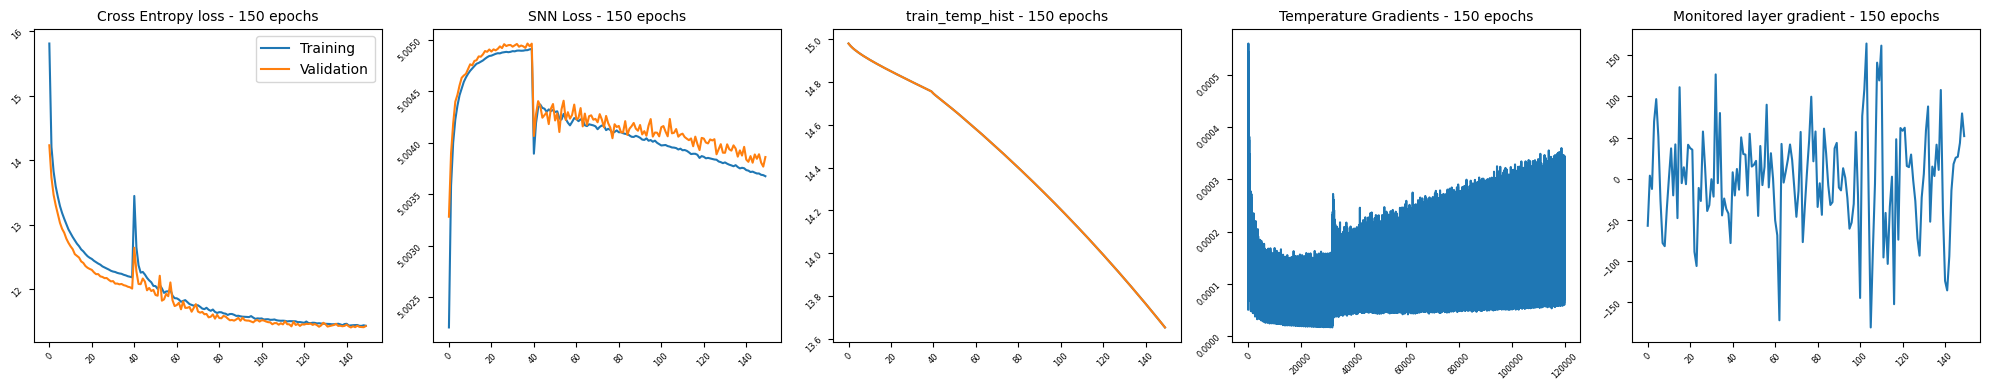

In [194]:
plot_train_history(model, n_bins = 25)

 +------+----------------------------------------------------+-------------------------------------------+------------------------------------+
 |      | Weights:                                           |  Biases:                                  |   Gradients:                       |
 | layr |                      min         max        stdev  |             min         max        stdev  |      min        max         stdev  |
 +------+----------------------------------------------------+-------------------------------------------+------------------------------------+
 |    0 | (1024, 1471)     -3.773015    2.005299    0.083236 |   1024  -4.407525    1.681713    0.993077 |  -0.013092    0.013503    0.000506 |
 |    1 | (128, 1024)      -0.247528    0.233778    0.038587 |    128  -0.454546    1.129462    0.220859 |  -0.263328    0.517531    0.011120 |
 |    2 | (50, 128)        -0.366935    0.398741    0.083337 |     50  -0.671407    0.491809    0.287755 |  -1.670144    1.463826    0.3

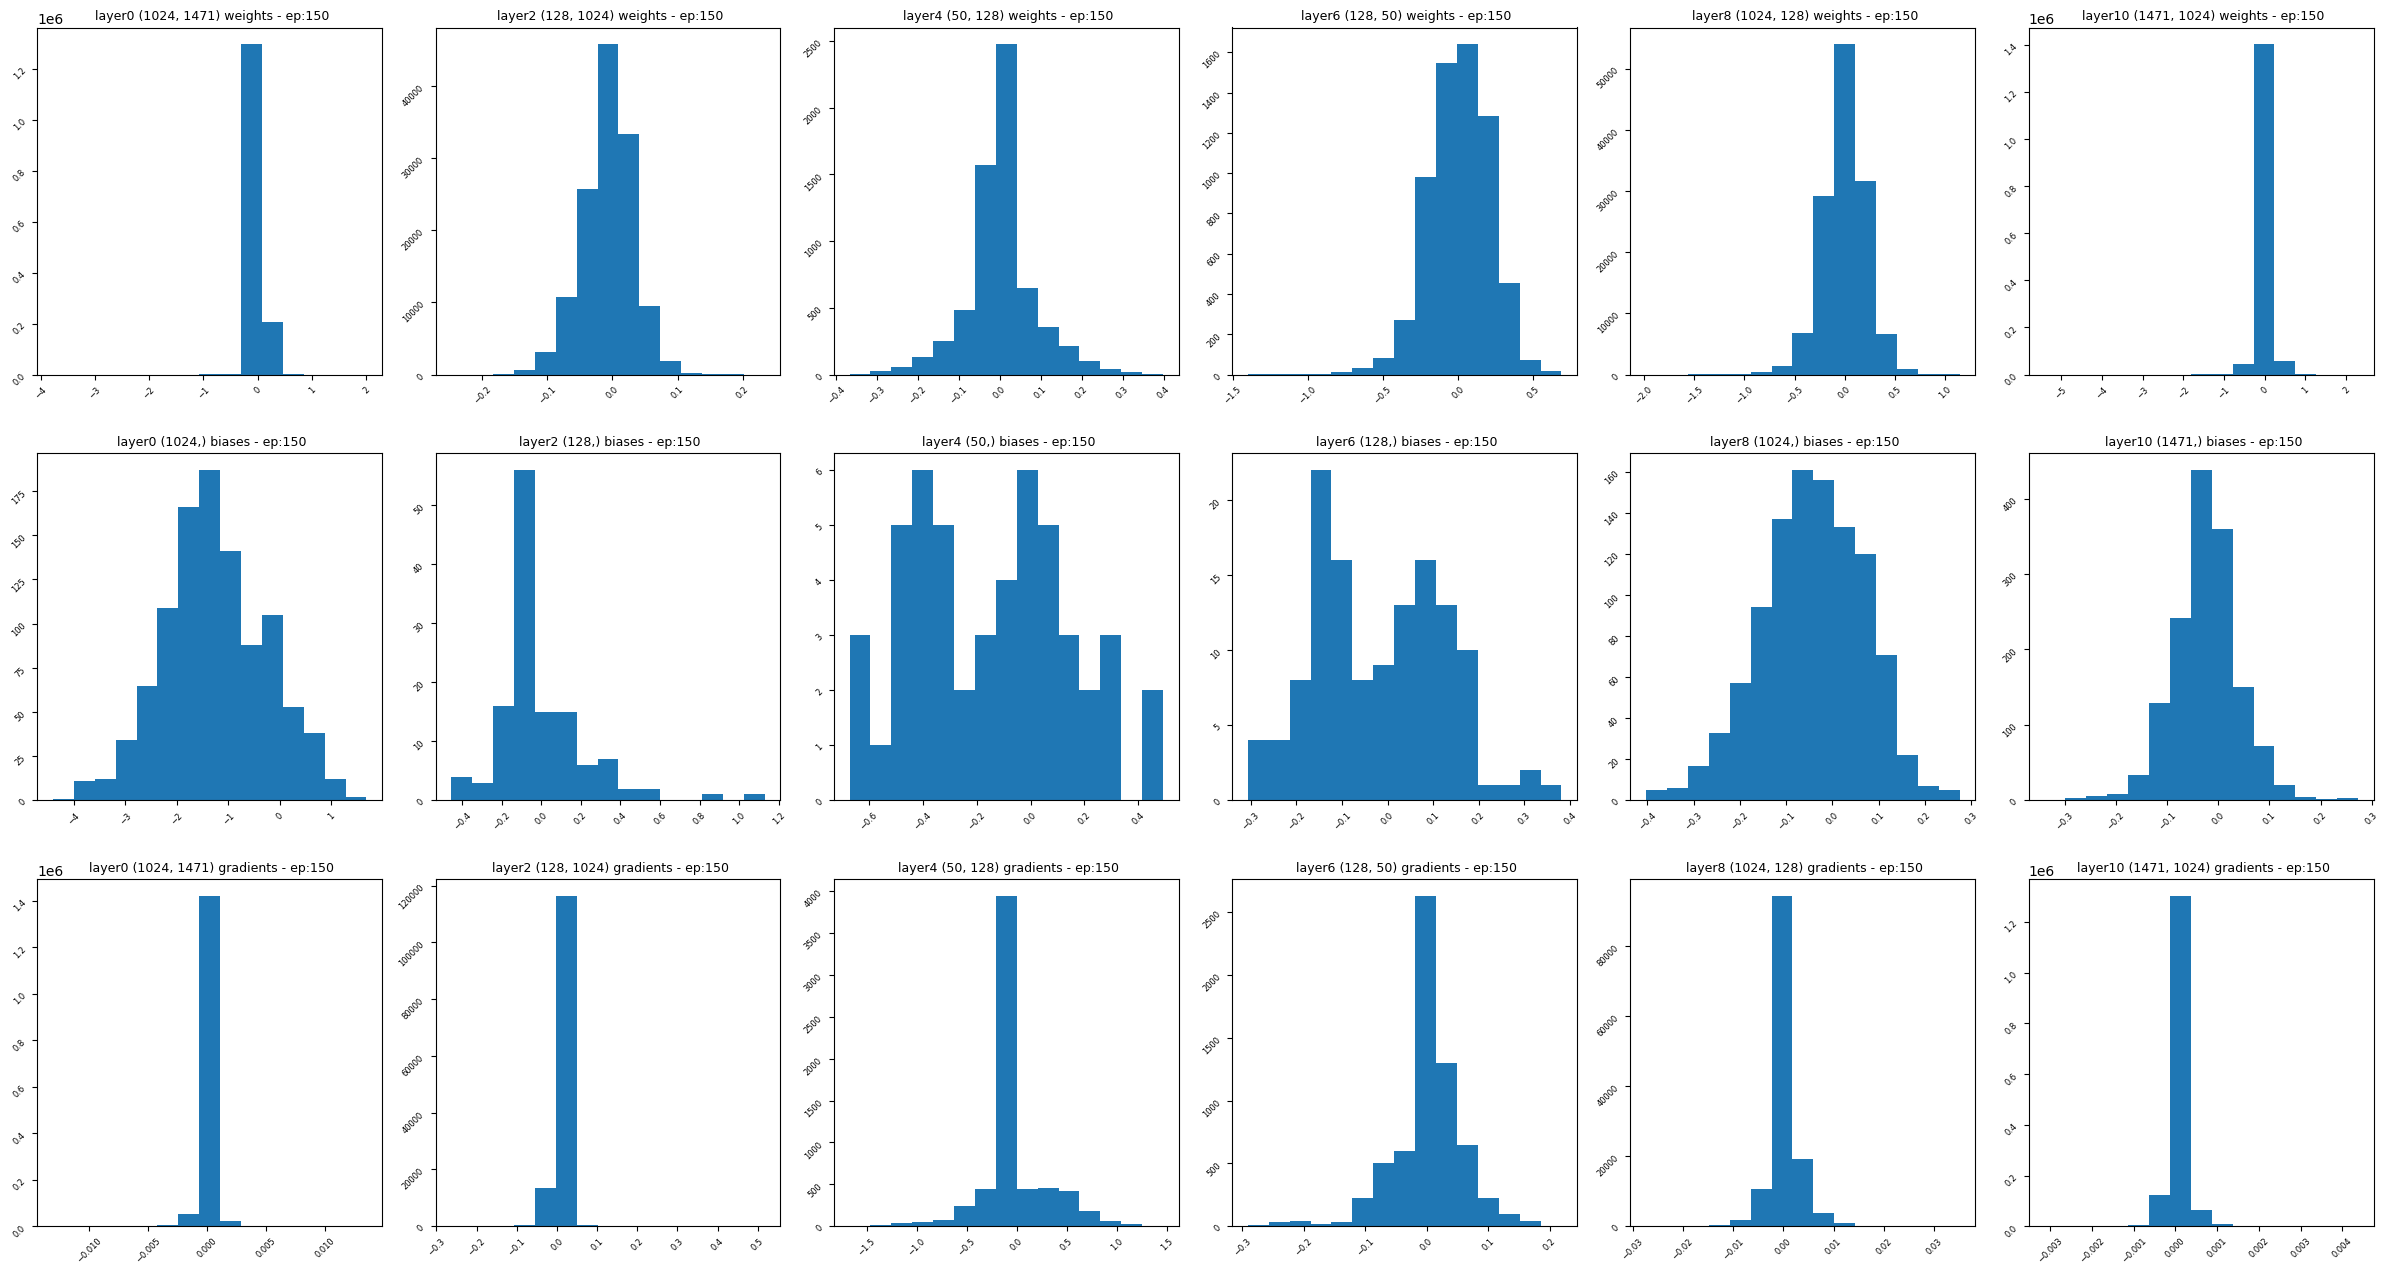

In [196]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

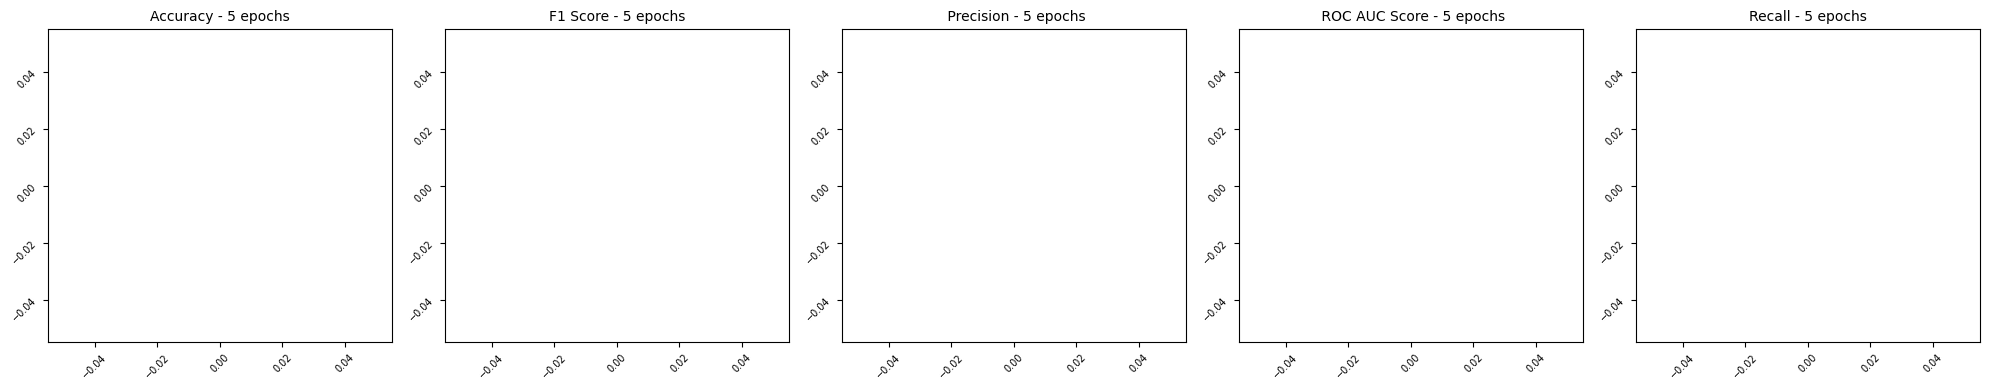

In [89]:
plot_train_metrics(model, n_bins = 25)

## Save model results and model

In [198]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
title="autoencoder"
filename = f"DNN_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

saved to DNN_snnl_20240501_autoencoder_150_cpb_100_factor_1


In [199]:
# save_model(model, filename)
export_results(model=model, filename=filename)
save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

[INFO] Model Results exported to results/DNN_snnl_20240501_autoencoder_150_cpb_100_factor_1.json.
[INFO] Model exported to ckpts/DNN_snnl_20240501_autoencoder_150_cpb_100_factor_1.pt.


# Step by step

### `epoch_train(model, data_loader, epoch)`

In [38]:
    # def epoch_train(
    #     self, data_loader: torch.utils.data.DataLoader, epoch: int = None
    # ) -> Tuple:

In [131]:
# model.snnl_criterion = SNNLoss(
#     mode=model.mode,
#     # criterion=criterion,
#     factor=model.factor,
#     temperature=model.temperature,
#     use_annealing=model.use_annealing,
#     use_sum=model.use_sum,
#     code_units=model.code_units,
#     stability_epsilon=model.stability_epsilon,
# )

 Build SNNLoss dfrom NOTEBOOK
 SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
 SNNLoss _init()_    -- primary_criterion: CrossEntropyLoss()


In [26]:
if model.use_snnl:
    epoch_primary_loss = 0
    epoch_snn_loss = 0
if model.name == "DNN" or model.name == "CNN":
    epoch_accuracy = 0
epoch_loss = 0

### Loop through data

In [27]:
# for batch_features, batch_labels in data_loader:
_,_,_,batch_features_numpy, batch_labels_numpy = next(iter(data_loader))

In [33]:
print(batch_features_numpy.min(0))
print(batch_features_numpy.max(0))

[-1.8321388 -1.8294874 -2.6065478 ... -1.2195314 -1.5166183 -1.6990108]
[2.4392388 2.4493015 3.0212164 ... 4.4669876 4.4819636 2.9044416]


In [29]:
print(f" batch features {type(batch_features_numpy)}   shape: {batch_features_numpy.shape}   {batch_features_numpy.ndim}")
print(f" batch features {type(batch_labels_numpy)}   shape: {batch_labels_numpy.shape}    {batch_labels_numpy.ndim}")

 batch features <class 'numpy.ndarray'>   shape: (96, 1471)   2
 batch features <class 'numpy.ndarray'>   shape: (96,)    1


In [30]:
batch_features = torch.from_numpy(batch_features_numpy).to(model.device)
batch_labels = torch.from_numpy(batch_labels_numpy).to(model.device)

print(f" batch features {type(batch_features)}   shape: {batch_features.shape}   device: {batch_features.device}")
print(f" batch features {type(batch_labels)}     shape: {batch_labels.shape}     device: {batch_labels.device}")

print(batch_labels)

 batch features <class 'torch.Tensor'>   shape: torch.Size([96, 1471])   device: cuda:0
 batch features <class 'torch.Tensor'>     shape: torch.Size([96])     device: cuda:0
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1], device='cuda:0', dtype=torch.int32)


In [147]:
# if model.name in ["Autoencoder", "DNN"]:
#     batch_features = batch_features.view(batch_features.shape[0], -1)

# batch_labels = torch.tensor([9,5,5,9])
 

In [31]:
model.optimizer.zero_grad()

In [32]:
outputs = model.forward(features=batch_features)

In [34]:
outputs.shape, outputs.device
batch_features.shape, batch_features.device


(torch.Size([96, 1471]), device(type='cuda', index=0))

(torch.Size([96, 1471]), device(type='cuda', index=0))

In [35]:
if model.use_snnl:
    train_loss, primary_loss, snn_loss = model.snnl_criterion(
        model=model,
        outputs=outputs,
        features=batch_features,
        labels=batch_labels,
        epoch=epoch,
    )

 call  primary_criterion(outputs, features)
    outputs:  <class 'torch.Tensor'>  cuda:0  torch.Size([96, 1471])
    features: <class 'torch.Tensor'>   cuda:0  torch.Size([96, 1471])


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print(f" train_loss {train_loss}, primary_loss {primary_loss}, snn_loss {snn_loss}")
epoch_loss += train_loss.item()
epoch_snn_loss += snn_loss.item()
epoch_primary_loss += primary_loss.item()

In [127]:
if not model.use_snnl:
    train_loss = model.criterion(outputs, batch_labels if model.name == "DNN" or model.name == "CNN"  else batch_features,)
    epoch_loss += train_loss.item()

In [35]:
if model.name == "DNN" or model.name == "CNN":
    train_accuracy = (outputs.argmax(1) == batch_labels).sum().item() / len(batch_labels)
    epoch_accuracy += train_accuracy

train_loss.backward()

model.optimizer.step()
if model.use_snnl and model.temperature is not None:
    model.optimize_temperature()

    # break

### End of dataloader loop

In [ ]:
epoch_loss /= len(data_loader)

if self.name in ["DNN", "CNN"]:
    epoch_accuracy /= len(data_loader)
    
if self.use_snnl:
    epoch_snn_loss /= len(data_loader)
    epoch_primary_loss /= len(data_loader)
    if self.name == "DNN" or self.name == "CNN":
        print(f" epoch_loss {epoch_loss}, epoch_snn_loss, {epoch_snn_loss},  epoch_primary_loss, {epoch_primary_loss}, epoch_accuracy,  {epoch_accuracy}")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss, epoch_accuracy
    else:
        print(f" epoch_loss {epoch_loss}, epoch_snn_loss, {epoch_snn_loss},  epoch_primary_loss, {epoch_primary_loss}")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss
else:
    if self.name == "DNN" or self.name == "CNN":
        print(f" epoch_loss {epoch_loss}, epoch_accuracy,  {epoch_accuracy}")
        return epoch_loss, epoch_accuracy
    else:
        print(f" epoch_loss {epoch_loss}")
        return epoch_loss

In [65]:
epoch_loss
batch_features.shape
# outputs[0].data
# outputs[1].data
batch_labels.data 
print(f" epoch_primary_loss  {epoch_primary_loss}")
print(f" epoch_snn_loss      {epoch_snn_loss}")
print(f" model.snnl_factor   {model.snnl_criterion.factor}")
print(f" epoch_loss          {epoch_loss}")
(outputs.argmax(1) == batch_labels).sum().item()
 
# train_accuracy
# epoch_accuracy
len(data_loader)

1152.2025146484375

torch.Size([4, 784])

tensor([8, 1, 7, 5], device='cuda:0')

 epoch_primary_loss  0.7071589231491089
 epoch_snn_loss      11.51495361328125
 model.snnl_factor   100.0
 epoch_loss          1152.2025146484375


0

2500

In [76]:
activations = dict()
layers = model.layers
for index, layer in enumerate(layers):
    if index == 0:
        activations[index] = layer(batch_features)
    else:
        activations[index] = layer(activations[index - 1])

In [78]:
for i in activations:
    print(activations[i].shape)

torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 512])
torch.Size([2, 10])


In [ ]:
epoch_loss /= len(data_loader)

if model.name in ["DNN", "CNN"]:
    epoch_accuracy /= len(data_loader)

if model.use_snnl:
    epoch_snn_loss /= len(data_loader)
    epoch_primary_loss /= len(data_loader)
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primaey_loss: {epoch_primary_loss}, accuracy: {epoch_accuracy} ")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss, epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primary_loss: {epoch_primary_loss} ")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss
else:
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss}, accuracy: {epoch_accuracy} ")
        return epoch_loss, epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},")
        return epoch_loss

In [ ]:
# def main(args):
#     (
#         dataset,
#         batch_size,
#         epochs,
#         learning_rate,
#         units,
#         snnl_factor,
#         temperature,
#     ) = get_hyperparameters(args.configuration)

#     set_global_seed(args.seed)

#     train_dataset, test_dataset = load_dataset(name=dataset)
#     if dataset == "emnist":
#         train_features = train_dataset.data.numpy().astype("float32") / 255.0
#         train_features = train_features[:60000]
#         train_features = torch.from_numpy(train_features)
#         train_labels = train_dataset.targets
#         train_labels = train_labels[:60000]
#         train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
#     train_loader = create_dataloader(dataset=train_dataset, batch_size=batch_size)

#     if args.model.lower() == "baseline":
#         model = DNN(units=units, learning_rate=learning_rate)
#     elif args.model.lower() == "snnl":
#         model = DNN(
#             units=units,
#             learning_rate=learning_rate,
#             use_snnl=True,
#             factor=snnl_factor,
#             temperature=temperature,
#             use_annealing=False,
#         )
#     else:
#         raise ValueError("Choose between [baseline] and [snnl] only.")

#     model.fit(data_loader=train_loader, epochs=epochs)

#     test_features = test_dataset.data.reshape(-1, 784) / 255.0
#     model.eval()
#     model = model.cpu()
#     predictions = model.predict(test_features)
#     model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)
#     print(f"accuracy: {model.test_accuracy}%")
#     filename = f"DNN-{args.model.lower()}-{args.seed}.json"
#     export_results(model=model, filename=filename)



### SNNL Loss

In [154]:
snnl = SNNLoss(temperature=1.0)

 Build SNNLoss dfrom NOTEBOOK


In [170]:
_ = torch.manual_seed(42)
features = torch.rand((6, 4))
features

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411, 0.4294],
        [0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317]])

In [171]:
distance_matrix = snnl.pairwise_cosine_distance(features)
distance_matrix

tensor([[-1.1921e-07,  2.6181e-02,  2.1361e-01,  1.0087e-01,  2.2940e-02,  7.3328e-02],
        [ 2.6181e-02,  0.0000e+00,  2.7807e-01,  1.8148e-01,  9.0106e-02,  1.6577e-02],
        [ 2.1361e-01,  2.7807e-01,  5.9605e-08,  6.2519e-02,  1.6466e-01,  2.7426e-01],
        [ 1.0087e-01,  1.8148e-01,  6.2519e-02,  0.0000e+00,  7.5882e-02,  2.2894e-01],
        [ 2.2940e-02,  9.0106e-02,  1.6466e-01,  7.5882e-02,  1.1921e-07,  1.4981e-01],
        [ 7.3328e-02,  1.6577e-02,  2.7426e-01,  2.2894e-01,  1.4981e-01,  0.0000e+00]])

In [173]:
pairwise_distance_matrix = snnl.normalize_distance_matrix(features, distance_matrix, device = 'cpu')
torch.exp(-(distance_matrix / snnl.temperature)) 
# pairwise_distance_matrix = torch.exp(-(distance_matrix / snnl.temperature)) - torch.eye(features.shape[0])
# pairwise_distance_matrix.sum(1)   
pairwise_distance_matrix

tensor([[1.0000, 0.9742, 0.8077, 0.9041, 0.9773, 0.9293],
        [0.9742, 1.0000, 0.7572, 0.8340, 0.9138, 0.9836],
        [0.8077, 0.7572, 1.0000, 0.9394, 0.8482, 0.7601],
        [0.9041, 0.8340, 0.9394, 1.0000, 0.9269, 0.7954],
        [0.9773, 0.9138, 0.8482, 0.9269, 1.0000, 0.8609],
        [0.9293, 0.9836, 0.7601, 0.7954, 0.8609, 1.0000]])

tensor([[ 1.1921e-07,  9.7416e-01,  8.0767e-01,  9.0405e-01,  9.7732e-01,  9.2930e-01],
        [ 9.7416e-01,  0.0000e+00,  7.5725e-01,  8.3404e-01,  9.1383e-01,  9.8356e-01],
        [ 8.0767e-01,  7.5725e-01, -5.9605e-08,  9.3940e-01,  8.4818e-01,  7.6013e-01],
        [ 9.0405e-01,  8.3404e-01,  9.3940e-01,  0.0000e+00,  9.2693e-01,  7.9538e-01],
        [ 9.7732e-01,  9.1383e-01,  8.4818e-01,  9.2693e-01, -1.1921e-07,  8.6087e-01],
        [ 9.2930e-01,  9.8356e-01,  7.6013e-01,  7.9538e-01,  8.6087e-01,  0.0000e+00]])

In [174]:
# torch.sum(pairwise_distance_matrix, 1) ##.view(-1, 1)
# pairwise_distance_matrix / (1.0e-8 + torch.sum(pairwise_distance_matrix, 1).view(-1, 1))

sampling_probability = snnl.compute_sampling_probability(pairwise_distance_matrix)
sampling_probability.sum(1)
sampling_probability

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

tensor([[ 2.5957e-08,  2.1212e-01,  1.7587e-01,  1.9685e-01,  2.1281e-01,  2.0235e-01],
        [ 2.1828e-01,  0.0000e+00,  1.6968e-01,  1.8688e-01,  2.0476e-01,  2.2039e-01],
        [ 1.9639e-01,  1.8413e-01, -1.4493e-08,  2.2842e-01,  2.0624e-01,  1.8483e-01],
        [ 2.0548e-01,  1.8956e-01,  2.1351e-01,  0.0000e+00,  2.1067e-01,  1.8078e-01],
        [ 2.1588e-01,  2.0186e-01,  1.8735e-01,  2.0475e-01, -2.6332e-08,  1.9016e-01],
        [ 2.1466e-01,  2.2719e-01,  1.7558e-01,  1.8372e-01,  1.9885e-01,  0.0000e+00]])

In [175]:
labels = torch.tensor([0,0,1,1,2,2])
# labels +=3
labels
labels.unsqueeze(1)
torch.eq(labels, labels.unsqueeze(1))

tensor([0, 0, 1, 1, 2, 2])

tensor([[0],
        [0],
        [1],
        [1],
        [2],
        [2]])

tensor([[ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False],
        [False, False,  True,  True, False, False],
        [False, False,  True,  True, False, False],
        [False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True]])

In [176]:
summed_masked_pick_probability = snnl.mask_sampling_probability(labels, sampling_probability)
# summed_masked_pick_probability.sum(0)
summed_masked_pick_probability

masking_matrix
tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.]])
masked_pick_probabliltiy
tensor([[ 2.5957e-08,  2.1212e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.1828e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.4493e-08,  2.2842e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.1351e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.6332e-08,  1.9016e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9885e-01,  0.0000e+00]])


tensor([0.2121, 0.2183, 0.2284, 0.2135, 0.1902, 0.1988])

### Predict

In [ ]:
test_features = test_dataset.data.reshape(-1, 784) / 255.0

In [ ]:
model.eval()
model = model.cpu()

In [ ]:
predictions = model.predict(test_features)
model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
filename = f"DNN-{args.model.lower()}-{args.seed}.json"
export_results(model=model, filename=filename)